# METYIS CHALLENGE

There are 6820 movies in the dataset (220 movies per year, 1986-2016). Each movie has the following attributes:

- budget: the budget of a movie. Some movies don't have this, so it appears as 0

- company: the production company

- country: country of origin

- director: the director

- genre: main genre of the movie.

- gross: revenue of the movie

- name: name of the movie

- rating: rating of the movie (R, PG, etc.)

- released: release date (YYYY-MM-DD)

- runtime: duration of the movie

- score: IMDb user rating

- votes: number of user votes

- star: main actor/actress

- writer: writer of the movie

- year: year of release

## SET ENVIRONMENT

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
import seaborn as sns
from statsmodels.formula.api import ols
import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor    
from scipy import stats
import klib
from sklearn.metrics import mean_absolute_error

## GET DATA 

In [2]:
# getting data from file
df_raw = pd.read_csv('../data/movies.csv')
df_raw.head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986
1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986
2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986
3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986
4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986


In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6820 entries, 0 to 6819
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   budget    6820 non-null   float64
 1   company   6820 non-null   object 
 2   country   6820 non-null   object 
 3   director  6820 non-null   object 
 4   genre     6820 non-null   object 
 5   gross     6820 non-null   float64
 6   name      6820 non-null   object 
 7   rating    6820 non-null   object 
 8   released  6820 non-null   object 
 9   runtime   6820 non-null   int64  
 10  score     6820 non-null   float64
 11  star      6820 non-null   object 
 12  votes     6820 non-null   int64  
 13  writer    6820 non-null   object 
 14  year      6820 non-null   int64  
dtypes: float64(3), int64(3), object(9)
memory usage: 799.3+ KB


In [4]:
# own functions to perform exploratory data analysis

def plot_histograms(df, figsize=(12,4)):
    """
    Plots a histogram for each one of the numerical varaibles in the dataset
    """
    # excludes categorical and datetimes variables
    num_features = df.select_dtypes(exclude=['object','datetime'])
    for feat in num_features.columns:
        fig, ax = plt.subplots(1,2, figsize=figsize)
        # histogram
        sns.histplot(num_features, x=feat, kde=True, ax=ax[0]) 
        ax[0].set(title='Histogram')
        # cumulative distribution function
        sns.histplot(num_features, x=feat, element='step', fill=False,
                     cumulative=True, stat='density', common_norm=False, ax=ax[1])
        ax[1].set(title='CDF')
        plt.suptitle(feat, fontsize=20)        
        plt.tight_layout()    
        
        
def plot_boxplot(df, figsize=(5,5)):
    """
    Plots a boxplot for each one of the numerical varaibles in the dataset
    """
    # excludes categorical and datetimes variables
    num_features = df.select_dtypes(exclude=['object','datetime'])
    for feat in num_features.columns:
        fig, ax = plt.subplots(figsize=figsize)
        sns.boxplot(y=num_features[feat]) 
        plt.tight_layout()  
        

def check_normality(df, alpha=0.05):
    """
    Tests the null hypothesis that a sample comes from a normal distribution
    
    Returns
    --------
    list with the names of normally distributed variables
    """
    
    # excludes categorical and datetimes variables
    num_features = df.select_dtypes(exclude=['object','datetime'])
    l_normal = []
    for feat in num_features.columns:    
        _, pvalue = stats.normaltest(df[feat].dropna()) # avoid eror if nans
        if pvalue >= alpha:
            l_normal.append(feat)
    return l_normal


def calculate_vif_(X, thresh=5):
    """
    Returns the dataset with features without collinearity
    """
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## EDA

In [5]:
seed = 42

In [6]:
df = df_raw.copy()
df = df.sample(frac=1, random_state=seed)

In [7]:
# replaces 0 by nans according to the description of the variable
df['budget'] = df['budget'].replace(0, np.nan)

In [8]:
df.isna().sum()

budget      2182
company        0
country        0
director       0
genre          0
gross          0
name           0
rating         0
released       0
runtime        0
score          0
star           0
votes          0
writer         0
year           0
dtype: int64

In [9]:
# changes released variable  to datetime
df['released'] = pd.to_datetime(df['released'])
df.dtypes

budget             float64
company             object
country             object
director            object
genre               object
gross              float64
name                object
rating              object
released    datetime64[ns]
runtime              int64
score              float64
star                object
votes                int64
writer              object
year                 int64
dtype: object

In [10]:
# range of released dates
start_date = df['released'].min().strftime('%d-%m-%Y')
final_date = df['released'].max().strftime('%d-%m-%Y')
print(f"There are films from {start_date} to {final_date}.")

There are films from 10-01-1986 to 23-11-2017.


In [11]:
# numerical variables
df.describe()

,budget,gross,runtime,score,votes,year
count,4.638000e+03,6.820000e+03,6820.00000,6820.000000,6.820000e+03,6820.000000
mean,3.614560e+07,3.349783e+07,106.55132,6.374897,7.121952e+04,2001.000293
std,3.996947e+07,5.819760e+07,18.02818,1.003142,1.305176e+05,8.944501
min,6.000000e+03,7.000000e+01,50.00000,1.500000,2.700000e+01,1986.000000
25%,1.000000e+07,1.515839e+06,95.00000,5.800000,7.665250e+03,1993.000000
50%,2.300000e+07,1.213568e+07,102.00000,6.400000,2.589250e+04,2001.000000
75%,4.600000e+07,4.006534e+07,115.00000,7.100000,7.581225e+04,2009.000000
max,3.000000e+08,9.366622e+08,366.00000,9.300000,1.861666e+06,2016.000000


Exploring extreme values in runtime:

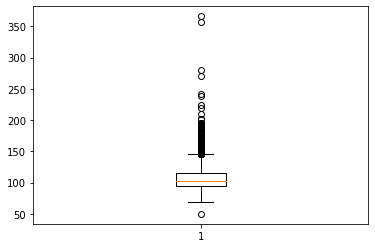

In [12]:
plt.boxplot(df['runtime']);

In [13]:
# observarions with runtime higher than 5 hours
df.loc[df['runtime']>300]

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
395,NaN,Sands,UK,Christine Edzard,Drama,1025228.0,Little Dorrit,G,1988-10-21,357,7.5,Derek Jacobi,886,Charles Dickens,1987
3890,NaN,BiBi Film,Italy,Marco Tullio Giordana,Drama,254224.0,The Best of Youth,R,2003-06-20,366,8.5,Luigi Lo Cascio,17585,Sandro Petraglia,2003


The Best of Youth and Little Dorrit according filmaffinity are series and not films, so we exlude both observations because they do not come from the same distribution of the population of interest.

In [14]:
# dropping series
df.drop(df.loc[df['runtime']>300].index, inplace=True)

In [15]:
# categorical variables
df.describe(include='object')

,company,country,director,genre,name,rating,star,writer
count,6818,6818,6818,6818,6818,6818,6818,6818
unique,2177,57,2757,17,6729,13,2503,4198
top,Universal Pictures,USA,Woody Allen,Comedy,Pulse,R,Nicolas Cage,Woody Allen
freq,302,4872,33,2080,3,3391,42,32


In [16]:
# quick EDA
profile = ProfileReport(df, minimal=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

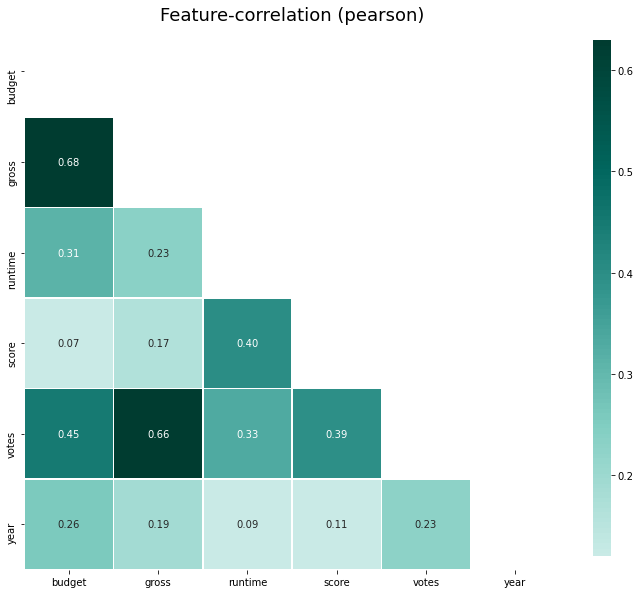

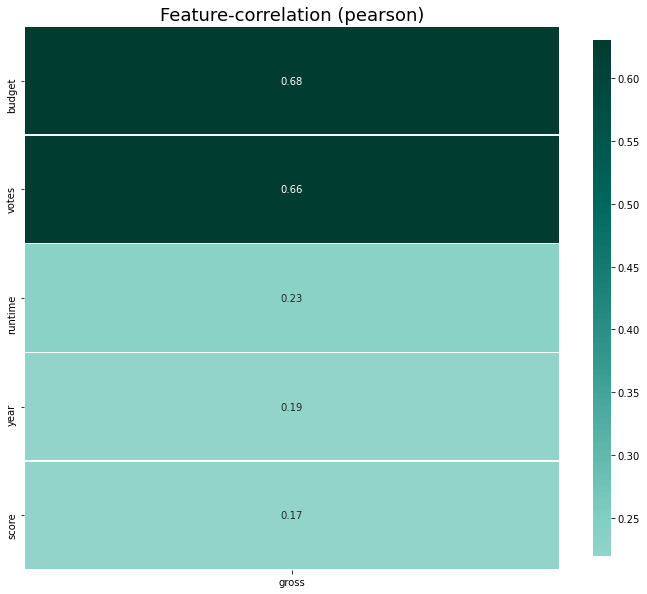

In [17]:
# correlation between variables
klib.corr_plot(df);
klib.corr_plot(df, target='gross');

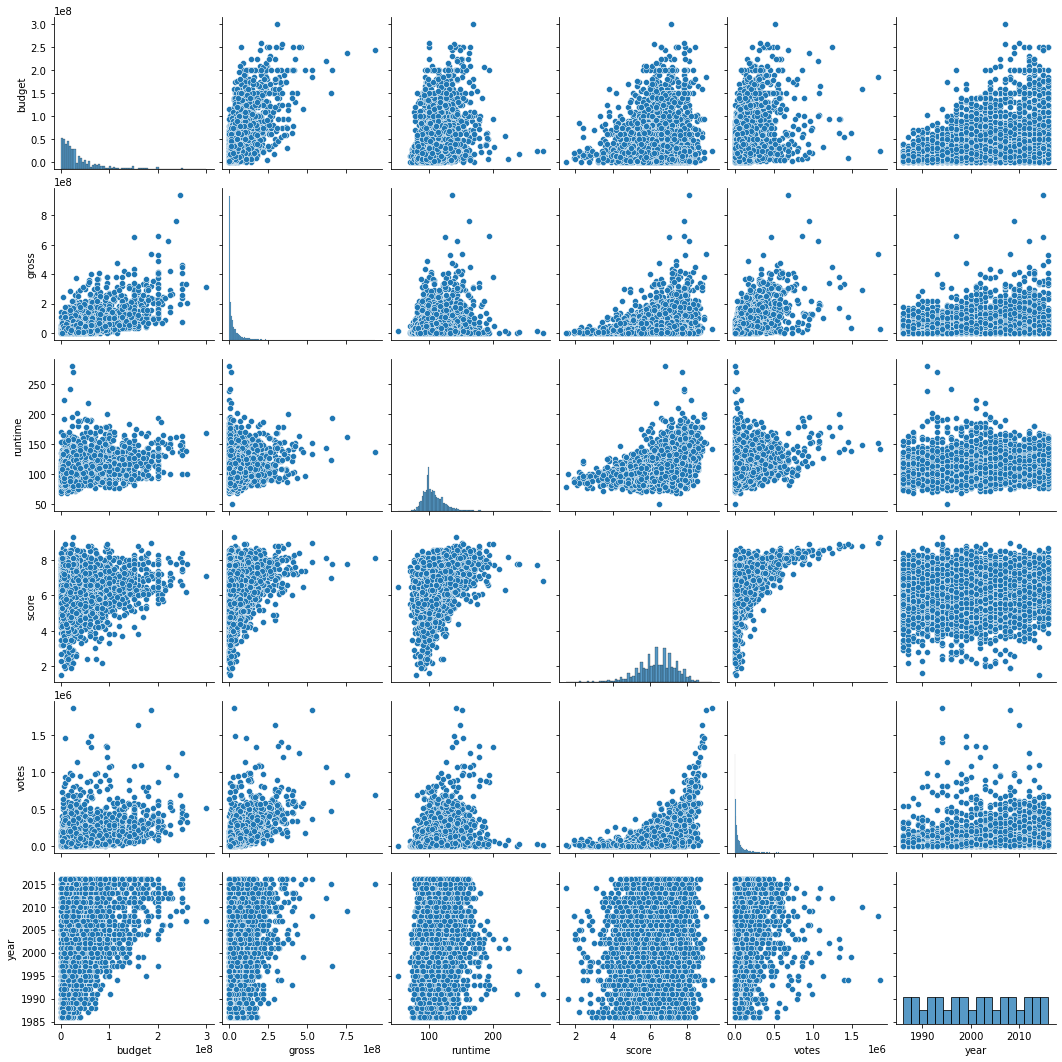

In [18]:
# scatterplots between variables
sns.pairplot(df)

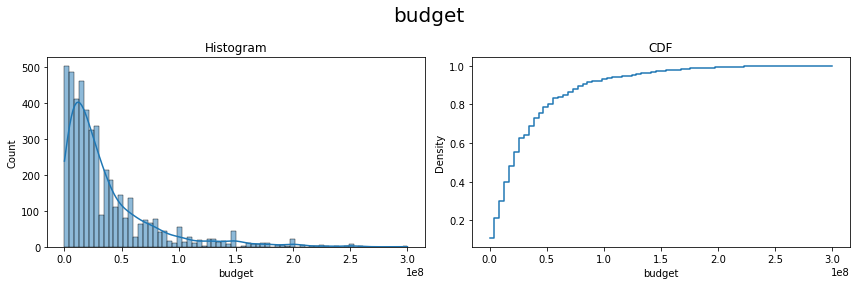

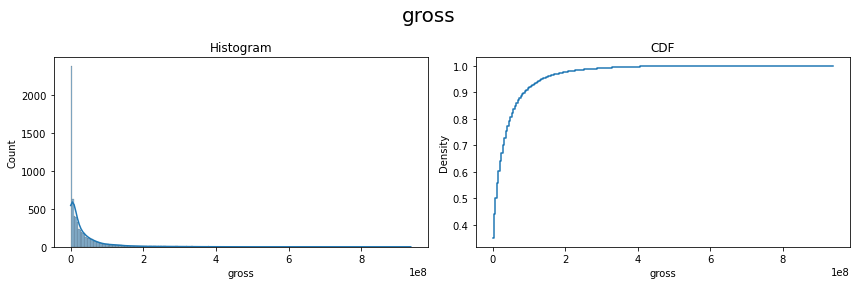

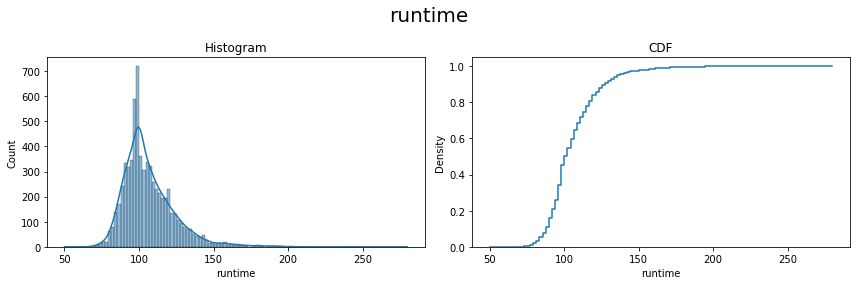

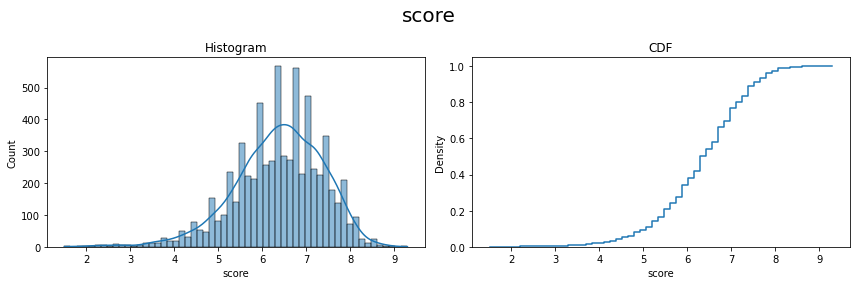

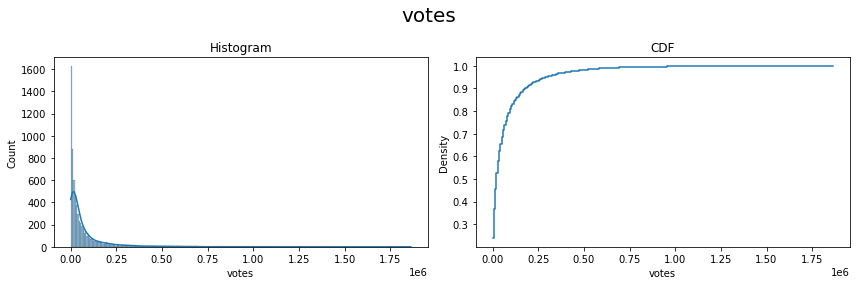

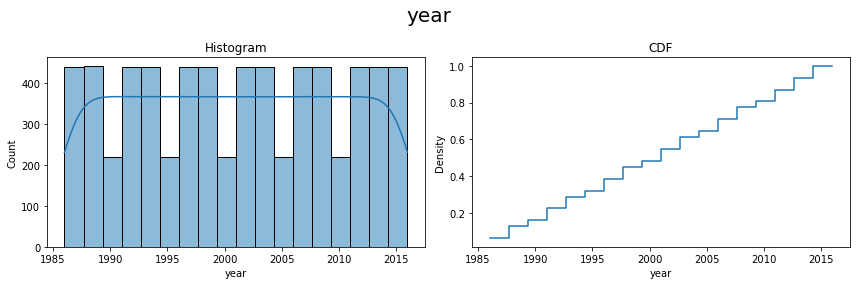

In [19]:
plot_histograms(df)

In [20]:
# checking variables normaly distributed
check_normality(df, 0.05)

[]

Summary:

- It does not appear that there is any wrong or weird value in the data.
- None of the distributions pass the normality test, despite the fact that runtime and score variables are visually closer to a normal distribution than the rest.
- Budget, gross and votes variables are right-skewed.
- Apply log-transformation to numerical variables if needed (linear models usually work better on normalized data)

## FEATURE ENGINEERING

In [21]:
# log-transformations to reduce the skewness of the data
features = ['budget', 'gross', 'votes']
for feat in features:
    featname = f"{feat}_log"
    df[featname] = np.log(df[feat])

In [22]:
# adding month as a new categorical feature
df['month'] = df['released'].dt.month
df['month'] = df['month'].astype('str')

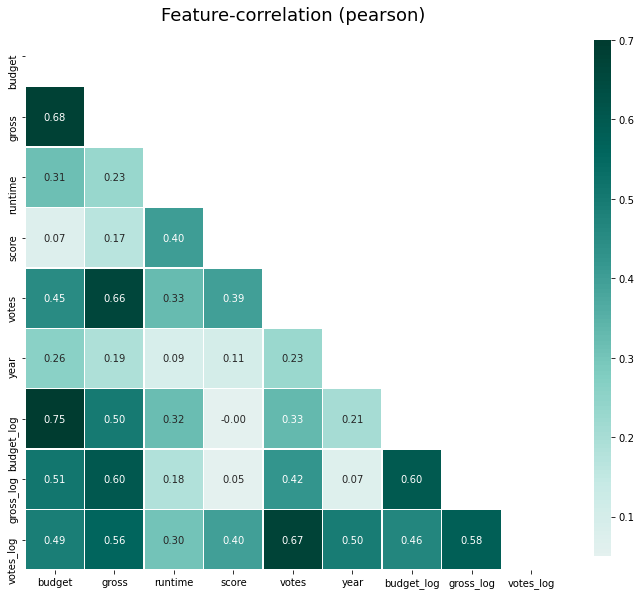

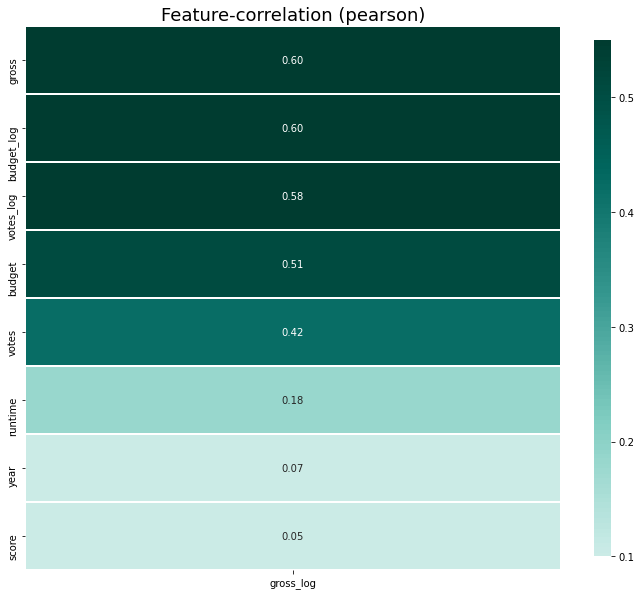

In [23]:
# correlation between variables
klib.corr_plot(df);
klib.corr_plot(df, target='gross_log');

## INSIGHTS

### QUESTION 1

**¿En qué género debería enfocarme?**

In [24]:
# number of observations by genre
df['genre'].value_counts()

Comedy       2080
Drama        1442
Action       1331
Crime         522
Adventure     392
Biography     359
Animation     277
Horror        277
Mystery        38
Fantasy        32
Thriller       18
Romance        15
Family         14
Sci-Fi         13
Musical         4
War             2
Western         2
Name: genre, dtype: int64

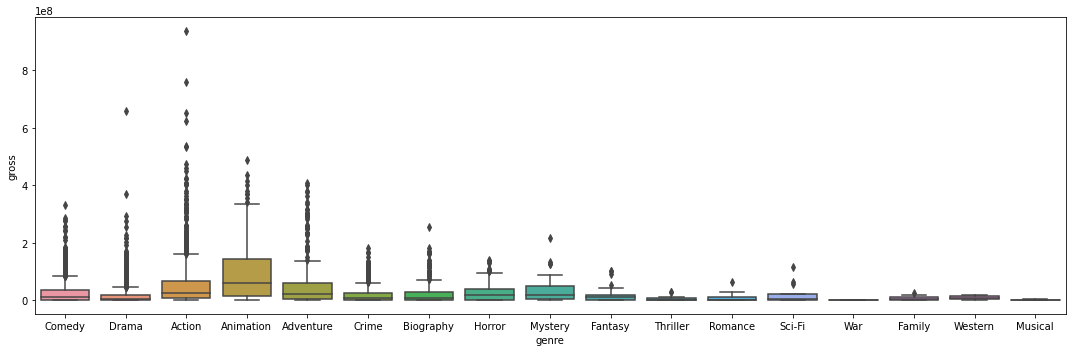

In [25]:
# boxplot by genre
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df, x='genre', y='gross')
plt.tight_layout()  

In [26]:
# summary statistics by genre
df_genre = df[['gross','genre']].groupby('genre').describe()
df_genre.columns = df_genre.columns.droplevel()
df_genre.sort_values(by='50%', ascending=False, inplace=True) # sorting by median (more robust statistic than mean)
df_genre

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
Animation,277.0,9.148810e+07,9.697904e+07,5274.0,13596911.00,58867694.0,1.435286e+08,486295561.0
Action,1331.0,5.619281e+07,8.364603e+07,547.0,6914048.50,26873932.0,6.859523e+07,936662225.0
Adventure,392.0,5.330381e+07,8.102622e+07,10230.0,5966297.25,20839239.0,5.893822e+07,408010692.0
Mystery,38.0,3.631451e+07,4.760927e+07,68877.0,4900544.25,19370067.5,5.112538e+07,217536138.0
Horror,277.0,2.569620e+07,2.895057e+07,70.0,1261000.00,17185632.0,3.956900e+07,140539099.0
Fantasy,32.0,2.014541e+07,2.861964e+07,3478.0,1657111.25,11034888.0,2.023836e+07,101071502.0
Comedy,2080.0,2.574203e+07,3.742141e+07,309.0,1687347.25,10912053.5,3.467921e+07,330252182.0
Western,2.0,9.259547e+06,1.277099e+07,229094.0,4744320.50,9259547.0,1.377477e+07,18290000.0
Biography,359.0,2.400425e+07,3.689086e+07,2670.0,1650605.50,8323085.0,3.060400e+07,255959475.0


In [27]:
# feature selection
# dropping features with high cardinality and budget because has high collinearity with other variables and
# has high percentatge of nans

# feat_subset = ['gross', 'genre', 'rating', 'runtime', 'score', 'year', 'budget_log', 'gross_log', 'votes_log', 'month']
feat_subset = ['gross', 'genre', 'rating', 'runtime', 'score', 'year', 'gross_log', 'votes_log', 'month']

df_sub = df[feat_subset]
df_sub.dropna(inplace=True)

<ipython-input-27-b34bf43db493>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.dropna(inplace=True)


In [28]:
df_sub.shape

(6818, 9)

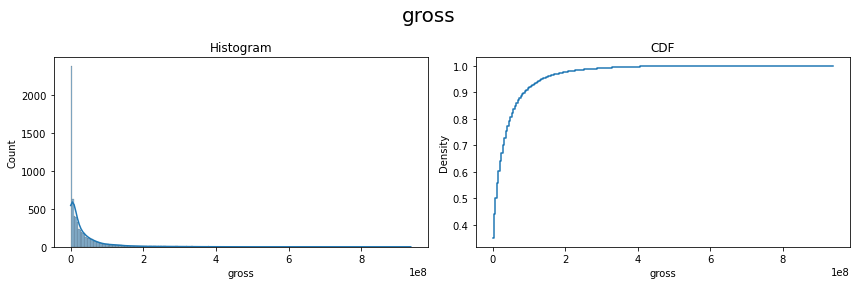

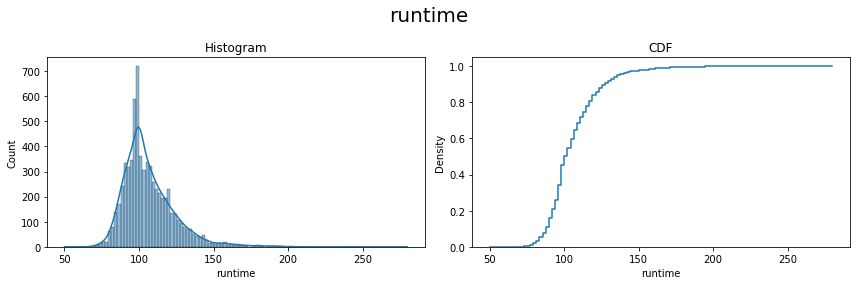

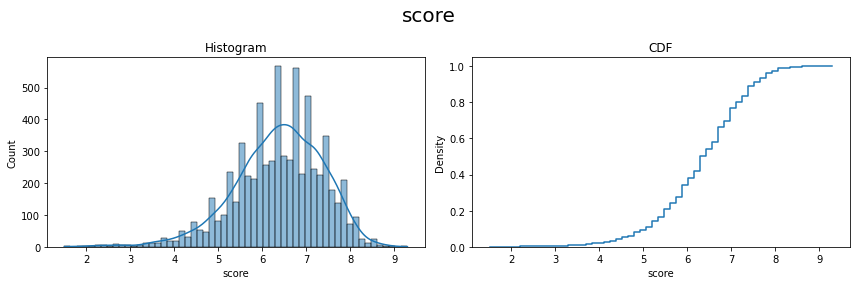

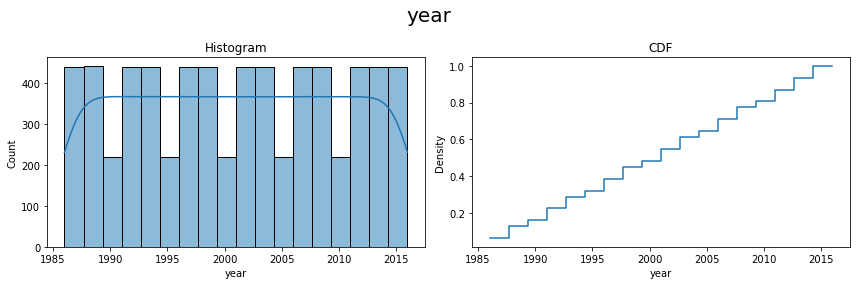

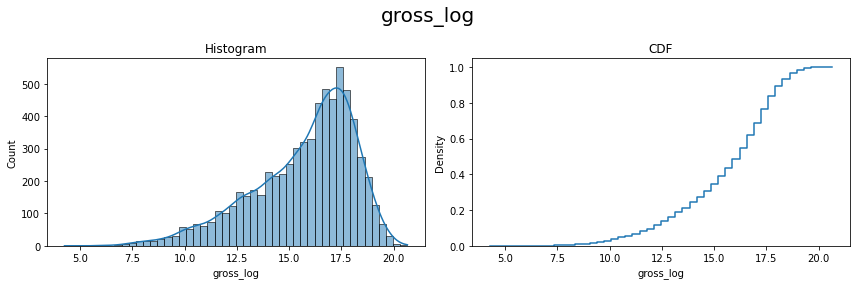

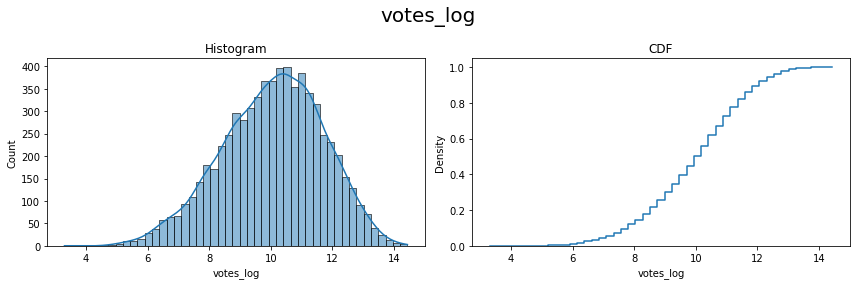

In [29]:
plot_histograms(df_sub)

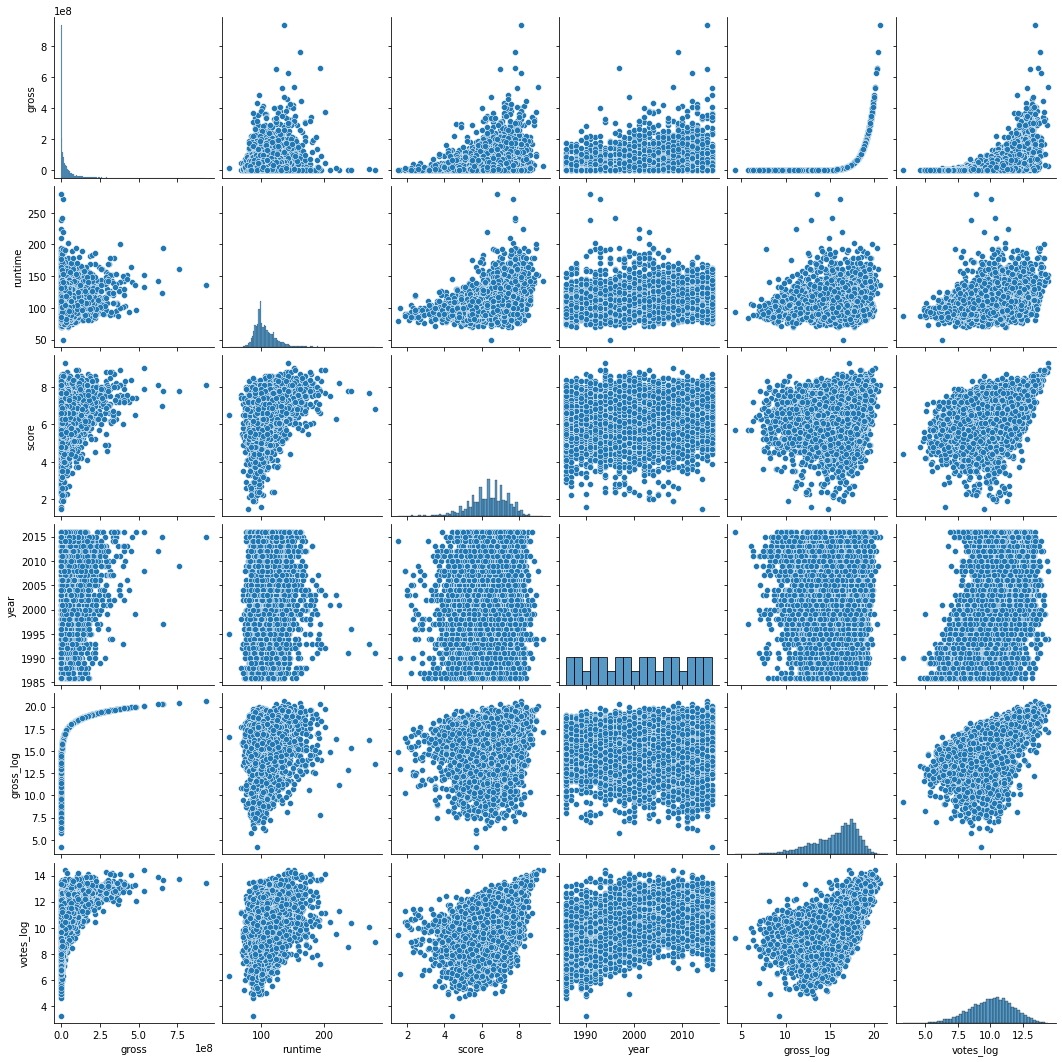

In [30]:
sns.pairplot(df_sub)

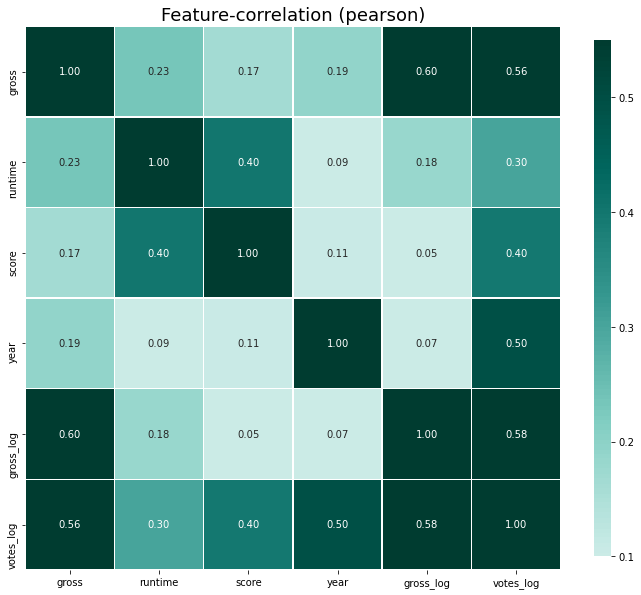

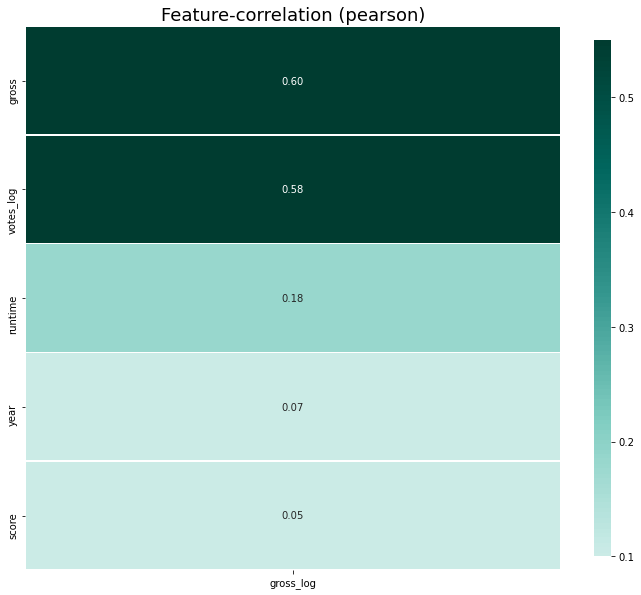

In [31]:
# correlation between variables
klib.corr_plot(df_sub, mask=False);
klib.corr_plot(df_sub, target='gross_log');

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     122.5
Date:                Sun, 14 Feb 2021   Prob (F-statistic):               0.00
Time:                        21:24:50   Log-Likelihood:            -1.2961e+05
No. Observations:                6818   AIC:                         2.593e+05
Df Residuals:                    6774   BIC:                         2.596e+05
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

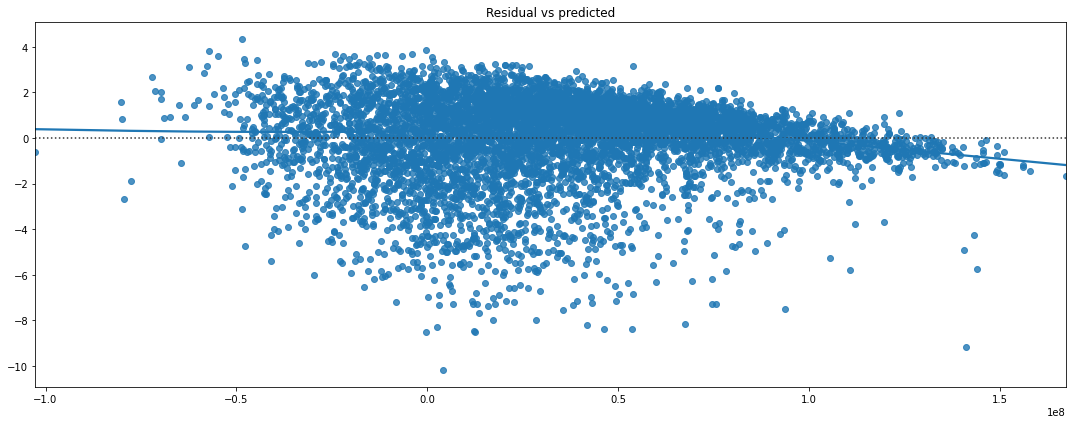

In [32]:
# choosing as baseline for genre Comedy, since its the genre with highest number of observations
equation = """
gross ~ runtime + score + year + votes_log + C(genre, Treatment(reference='Comedy')) + C(rating)+ C(month)
"""

mod = ols(equation, data=df_sub)
res = mod.fit()
print(res.summary())

residuals = df_sub['gross_log'] - res.fittedvalues
fig, ax = plt.subplots(figsize=(15,6))
sns.residplot(x=res.fittedvalues, y=residuals, lowess=True, ax=ax)
plt.title("Residual vs predicted")
plt.tight_layout()  

y_true = df_sub['gross']
y_pred = res.fittedvalues
print(f"MAE:{mean_absolute_error(y_true, y_pred)}")
print(F"MAPE:{mean_absolute_percentage_error(y_true, y_pred)}")

Using log-transformation of response variable:

                            OLS Regression Results                            
Dep. Variable:              gross_log   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     201.0
Date:                Sun, 14 Feb 2021   Prob (F-statistic):               0.00
Time:                        21:24:55   Log-Likelihood:                -12966.
No. Observations:                6818   AIC:                         2.602e+04
Df Residuals:                    6774   BIC:                         2.632e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

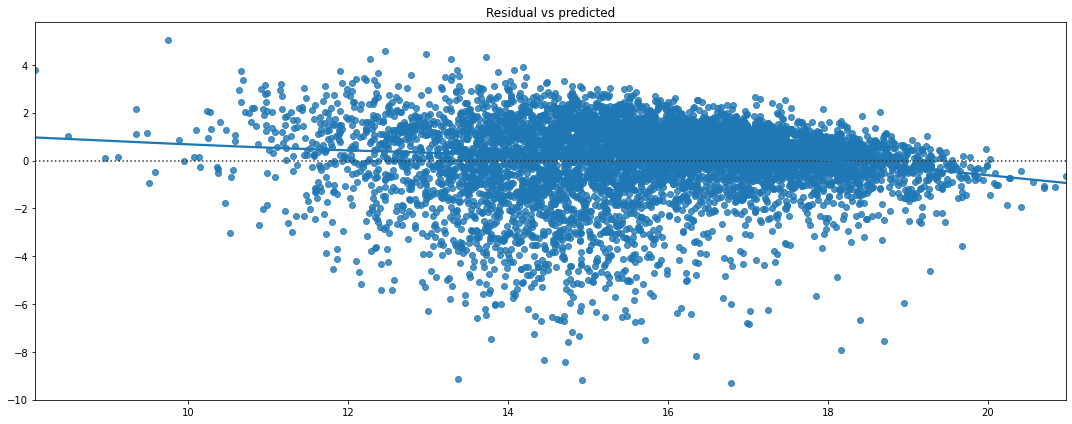

In [33]:
equation = """
gross_log ~ runtime + score + year  + votes_log + C(genre, Treatment(reference='Comedy')) +
            C(rating)+ C(month)
"""

mod = ols(equation, data=df_sub)
res = mod.fit()
print(res.summary())

residuals = df_sub['gross_log'] - res.fittedvalues
fig, ax = plt.subplots(figsize=(15,6))
sns.residplot(x=res.fittedvalues, y=residuals, lowess=True, ax=ax)
plt.title("Residual vs predicted")
plt.tight_layout()  

y_true = np.exp(df_sub['gross_log'])
y_pred = np.exp(res.fittedvalues)
print(f"MAE:{mean_absolute_error(y_true, y_pred)}")
print(F"MAPE:{mean_absolute_percentage_error(y_true, y_pred)}")

There is multicolliniarity in the data?

In [34]:
X = df_sub.drop(['gross', 'gross_log'], axis=1).select_dtypes(exclude='object')
X.columns

Index(['runtime', 'score', 'year', 'votes_log'], dtype='object')

In [35]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,46.642665,runtime
1,54.684370,score
2,68.864845,year
3,48.044772,votes_log


In [36]:
X = X.drop('year', axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,39.419636,runtime
1,47.478112,score
2,39.572847,votes_log


In [37]:
X = X.drop('runtime', axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,33.447034,score
1,33.447034,votes_log


In [41]:
# genre with highest coeff is Animation
# betta=0.5706      conf_int=[0.328   0.813]

print(np.exp(0.5706))
print(np.exp(0.328))
print(np.exp(0.813))

1.7693283300163318
1.3881889722894125
2.254661836345618


Summary:

- We have few data about Musical, War and Western genres, so the inference involving that genres can be not accurate
- Log-transforming response variable we get higher coefficient of determination.
- There is multicolliniarity in the data, however it exist between numerical variables, so it is not affecting genre variable.
- The genre with the highest median gross is animation (using median instead of mean since it is more robust against extreme values).
- Switching from Comedy genre (the most produced) to Animation genre, we expect to see about 77% increase in the geometric mean of gross value, when other variables are held at some fixed value.
- We are 95% confident that switching from Comedy genre to Animation genre increase the gross between 38% and 125%. (if we were to collect new data generated from the same distribution then in 19 out of every 20 experiments we'd get a coefficient interval including the real value of the coefficient)
- There is no significant evidence that another gender increases the value of the gross.

**¿Qué tan importante es producir una buena película (rating IMDB alto) para obtener muchos ingresos?**

                            OLS Regression Results                            
Dep. Variable:              gross_log   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     64.84
Date:                Sun, 14 Feb 2021   Prob (F-statistic):               0.00
Time:                        21:27:43   Log-Likelihood:                -14664.
No. Observations:                6818   AIC:                         2.941e+04
Df Residuals:                    6777   BIC:                         2.969e+04
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
                                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------

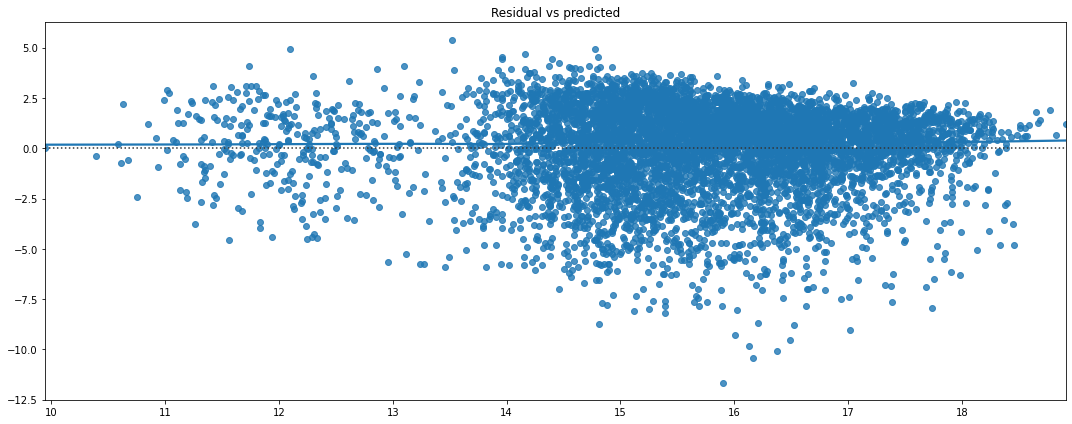

In [42]:
equation = """
gross_log ~ score + C(genre, Treatment(reference='Comedy')) + C(rating)+ C(month)
"""

mod = ols(equation, data=df_sub)
res = mod.fit()
print(res.summary())

residuals = df_sub['gross_log'] - res.fittedvalues
fig, ax = plt.subplots(figsize=(15,6))
sns.residplot(x=res.fittedvalues, y=residuals, lowess=True, ax=ax)
plt.title("Residual vs predicted")
plt.tight_layout()  

In [43]:
# betta=0.4028      conf_int=[0.349  0.456]

print(np.exp(0.4028))
print(np.exp(0.349))
print(np.exp(0.456))

1.4960076602093928
1.417649190341986
1.577750344766478


* For a one-unit increasing in score, we expect to see about a 50% increase in gross. 

* We are 95% confident that for a one-unit increasing in score, we expect to see about a 42% to 58% increase in gross.

**¿Es mejor producir una película para todos los públicos? ¿O una dirigida sólo al público adulto?**

**¿Hay algún actor que garantice el éxito de la película? ¿Y director?**

# FINAL